CS4001/4042 Assignment 1
---
Part A, Q1 (15 marks)
---

>Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers. 

In [3]:
!pip install librosa

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import time
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed(10)


Define the model class.

In [6]:
no_features = 57
no_hidden = 128
no_labels = 2

no_epochs = 100
batch_size = 128
lr = 0.001
patience = 3

In [7]:
class MLP(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels, drop_out = 0.2):
        super().__init__()
        self.relu_stack = nn.Sequential(
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.relu_stack(x)
        return logits
        
        
        
# TODO: Enter your code here

> Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

Split the dataset and do preprocessing. You can use the split_dataset and preprocess_dataset provided for you.

In [10]:
from common_utils import split_dataset, preprocess_dataset
df = pd.read_csv("audio_gtzan.csv")
df["label"] = df["filename"].str[:5]
df_train2, y_train2, df_test2, y_test2 = split_dataset(df, columns_to_drop = ["filename", 'label'], test_size = 0.3, random_state = 42)
df_train_scaled, df_test_scaled = preprocess_dataset(df_train2, df_test2)

print(df_train_scaled.shape, y_train2.shape)
print(df_test2.shape, y_test2.shape)

(1400, 57) (1400,)
(600, 57) (600,)


In [11]:
df['label'].value_counts()

label
0    1000
1    1000
Name: count, dtype: int64

> Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [14]:
# TODO: Enter your code here

class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float) 
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X) 

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]  

train_dataset = AudioDataset(df_train_scaled, y_train2)
test_dataset = AudioDataset(df_test_scaled, y_test2)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


2. Next, define the model, optimizer and loss function.

In [16]:
# TODO: Enter your code here

model = MLP(no_features, no_hidden, no_labels, drop_out = 0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [17]:
for X_batch, y_batch in train_loader:
    print("X_batch shape:", X_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break


X_batch shape: torch.Size([128, 57])
y_batch shape: torch.Size([128])


3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [19]:
from common_utils import EarlyStopper

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
num_epochs = 100
early_stopper = EarlyStopper(patience = 3, min_delta=0)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == y_batch).sum().item()
        total   += y_batch.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc  = 100.0 * correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    model.eval()
    running_loss_test = 0.0
    correct_test, total_test = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            running_loss_test += loss.item() * X_batch.size(0)

            _, predicted = torch.max(outputs, dim=1)
            correct_test += (predicted == y_batch).sum().item()
            total_test   += y_batch.size(0)

    epoch_test_loss = running_loss_test / len(test_loader.dataset)
    epoch_test_acc  = 100.0 * correct_test / total_test
    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]"
          f" | Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%"
          f" | Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%")


    if early_stopper.early_stop(epoch_test_loss):
        print("Early stopping triggered at epoch:", epoch + 1)
        break




Epoch [1/100] | Train Loss: 0.6615, Train Acc: 69.21% | Test Loss: 0.6030, Test Acc: 84.33%
Epoch [2/100] | Train Loss: 0.5503, Train Acc: 84.07% | Test Loss: 0.4921, Test Acc: 85.17%
Epoch [3/100] | Train Loss: 0.4567, Train Acc: 87.07% | Test Loss: 0.4261, Test Acc: 88.83%
Epoch [4/100] | Train Loss: 0.4071, Train Acc: 90.71% | Test Loss: 0.4020, Test Acc: 91.33%
Epoch [5/100] | Train Loss: 0.3822, Train Acc: 93.14% | Test Loss: 0.3908, Test Acc: 92.17%
Epoch [6/100] | Train Loss: 0.3718, Train Acc: 94.36% | Test Loss: 0.3848, Test Acc: 92.50%
Epoch [7/100] | Train Loss: 0.3618, Train Acc: 95.00% | Test Loss: 0.3739, Test Acc: 94.00%
Epoch [8/100] | Train Loss: 0.3527, Train Acc: 95.93% | Test Loss: 0.3692, Test Acc: 94.17%
Epoch [9/100] | Train Loss: 0.3428, Train Acc: 97.14% | Test Loss: 0.3598, Test Acc: 95.50%
Epoch [10/100] | Train Loss: 0.3373, Train Acc: 97.79% | Test Loss: 0.3559, Test Acc: 95.83%
Epoch [11/100] | Train Loss: 0.3330, Train Acc: 98.57% | Test Loss: 0.3544, Tes

> Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.

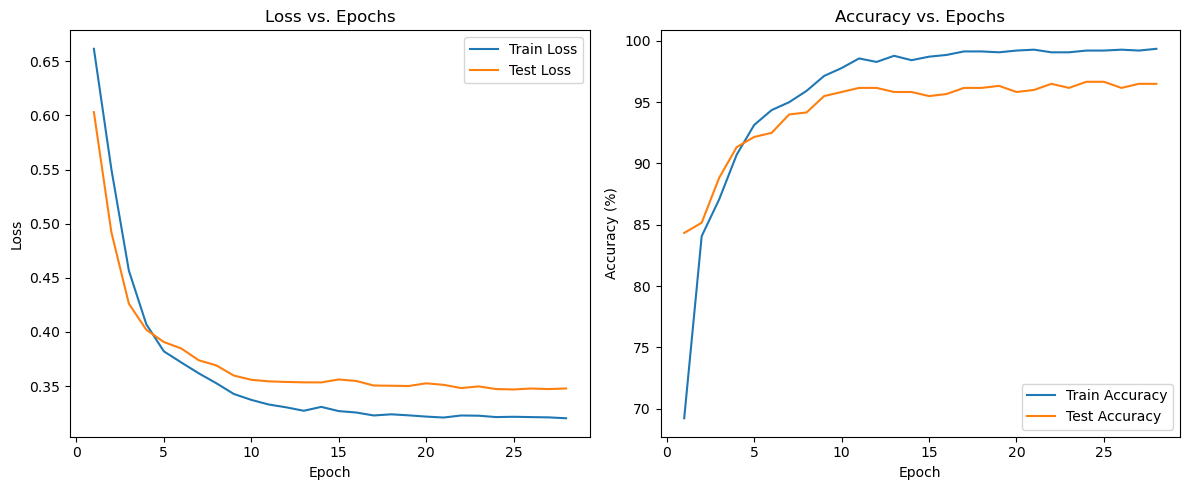

In [21]:
# TODO: Enter your code here


import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

# ----- Subplot 1: Loss vs. Epochs -----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# ----- Subplot 2: Accuracy vs. Epochs -----
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

\# TODO: \<Enter your answer here\>

Part A, Q2 (10 marks)
---

In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

To reduce repeated code, you may need to place the network (MLP defined in QA1) in a separate file called **common_utils.py**. Import it here for Q2. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [24]:
# TODO: Enter your code here

from common_utils import MLP

> Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {32, 64, 128, 256}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection. This might take a while to run, so plan your time carefully.

1. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly. Please use the following name conventions:
    - X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds. 
    - X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds. 
    - y_train_dict[batch_size] and y_val_dict[batch_size] is a list of labels for the different folds.

In [27]:
# TODO: Enter your code here

from sklearn.preprocessing import StandardScaler


batch_size = [32, 64, 128, 256]
n = 5

def folds_for_batchs(size, df_train2, y_train2):
    X_train_scaled_dict= {}
    X_val_scaled_dict = {}
    y_train_dict = {}
    y_val_dict = {}

    for batch_size in size:
        X_train_folds = []
        X_val_folds = []
        y_train_folds = []
        y_val_folds = []

        kf = KFold(n_splits = n, shuffle = True, random_state = 42)
        for train_idx, val_idx in kf.split(df_train2, y_train2):
            X_train_fold, X_val_fold = df_train2[train_idx], df_train2[val_idx]
            y_train_fold, y_val_fold = y_train2[train_idx], y_train2[val_idx]
            
            scaler = StandardScaler()
            X_train_fold_scaled = scaler.fit_transform(X_train_fold)
            X_val_fold_scaled = scaler.transform(X_val_fold)

            X_train_folds.append(X_train_fold_scaled)
            X_val_folds.append(X_val_fold_scaled)
            y_train_folds.append(y_train_fold)
            y_val_folds.append(y_val_fold)
        
        X_train_scaled_dict[batch_size] = X_train_folds #update dict
        X_val_scaled_dict[batch_size] = X_val_folds
        y_train_dict[batch_size] = y_train_folds
        y_val_dict[batch_size] = y_val_folds
    
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = folds_for_batchs(batch_size, df_train_scaled, y_train2)

print(y_train_dict)


{32: [array([0, 0, 0, ..., 0, 1, 1]), array([0, 0, 0, ..., 0, 1, 1]), array([0, 1, 1, ..., 0, 1, 1]), array([0, 0, 0, ..., 1, 1, 0]), array([0, 0, 1, ..., 1, 1, 1])], 64: [array([0, 0, 0, ..., 0, 1, 1]), array([0, 0, 0, ..., 0, 1, 1]), array([0, 1, 1, ..., 0, 1, 1]), array([0, 0, 0, ..., 1, 1, 0]), array([0, 0, 1, ..., 1, 1, 1])], 128: [array([0, 0, 0, ..., 0, 1, 1]), array([0, 0, 0, ..., 0, 1, 1]), array([0, 1, 1, ..., 0, 1, 1]), array([0, 0, 0, ..., 1, 1, 0]), array([0, 0, 1, ..., 1, 1, 1])], 256: [array([0, 0, 0, ..., 0, 1, 1]), array([0, 0, 0, ..., 0, 1, 1]), array([0, 1, 1, ..., 0, 1, 1]), array([0, 0, 0, ..., 1, 1, 0]), array([0, 0, 1, ..., 1, 1, 1])]}


2. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation. 

In [29]:
epoch_acc_dict = {}
epoch_time_dict = {}

def training_batch(X_train, y_train, X_val, y_val, batch_size):
    
    epochs = 100
    acc = []
    timings = []
    
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.LongTensor(y_val)

    train_dataset = AudioDataset(X_train_tensor, y_train_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = MLP(no_features= no_features, no_hidden=no_hidden, no_labels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)    
    early_stopper = EarlyStopper(patience=3, min_delta=0)
    
    start_time = time.time()
    
    for epoch in range(epochs):
        
        epoch_start = time.time()
        
        model.train()
        train_loss = 0.0
        
        for inputs, labels in train_dataloader:

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)


            optimizer.zero_grad()
            loss.backward()


            optimizer.step()
            train_loss += loss.item()
            

        model.eval()
        
        with torch.no_grad():
            val_predictions = model(X_val_tensor)
            val_loss = loss_fn(val_predictions, y_val_tensor)

            # Calculate accuracy on the validation fold
            predicted_labels = torch.argmax(val_predictions, dim=1)
            accuracy = torch.sum(predicted_labels == y_val_tensor).item() / len(y_val_tensor)
            acc.append(accuracy)
            


        if early_stopper.early_stop(val_loss.item()):

            epoch_end = time.time() - epoch_start
            timings.append(epoch_end)
            print(f"Early stopping triggered at epoch {epoch + 1}")
            print(f"Time Taken for Epoch: {epoch_end} s")
            break
            
    epoch_acc_dict[batch_size] = acc
    epoch_time_dict[batch_size] = timings
    training_time = time.time() - start_time

    return accuracy, training_time

In [30]:
# TODO: Enter your code here
def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, hyperparameter_name):
    optimal_hyperparameters = {}
    cross_validation_accuracies = []
    cross_validation_times = []

    for batch_size in batch_sizes:
        fold_accuracies = []
        fold_times = []

        for fold_idx in range(5):
            X_train_fold, y_train_fold = X_train_scaled_dict[batch_size][fold_idx], y_train_dict[batch_size][fold_idx]
            X_val_fold, y_val_fold = X_val_scaled_dict[batch_size][fold_idx], y_val_dict[batch_size][fold_idx]

            accuracy, training_time = training_batch(X_train_fold, y_train_fold, X_val_fold, y_val_fold, batch_size)
            fold_accuracies.append(accuracy)
            fold_times.append(training_time)
            
            print(f"Batch Size {batch_size}: | Fold {fold_idx+1} | Training Accuracy: {accuracy}")
            
        
        mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
        mean_time = sum(fold_times) / len(fold_times)


        print(f"Mean Training Time: {mean_time} s")
        print(f"Mean 5-Fold Cross Validation Accuracy: {mean_accuracy}")
        print("--------------------------------------------------------------------------")
        

        cross_validation_accuracies.append(mean_accuracy)
        cross_validation_times.append(mean_time)

        if hyperparameter_name not in optimal_hyperparameters:
            optimal_hyperparameters[hyperparameter_name] = []
        optimal_hyperparameters[hyperparameter_name].append(batch_size)
    
    #print(cross_validation_accuracies)
    return cross_validation_accuracies, cross_validation_times

cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_size, 'batch_size')

/var/folders/n5/z8b12shx2ql9049prv6m9mwm0000gn/T/ipykernel_37251/893739162.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float)
/var/folders/n5/z8b12shx2ql9049prv6m9mwm0000gn/T/ipykernel_37251/893739162.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)


Early stopping triggered at epoch 10
Time Taken for Epoch: 0.028728008270263672 s
Batch Size 32: | Fold 1 | Training Accuracy: 0.9928571428571429
Early stopping triggered at epoch 16
Time Taken for Epoch: 0.028048992156982422 s
Batch Size 32: | Fold 2 | Training Accuracy: 0.9607142857142857
Early stopping triggered at epoch 15
Time Taken for Epoch: 0.02652597427368164 s
Batch Size 32: | Fold 3 | Training Accuracy: 0.9892857142857143
Early stopping triggered at epoch 13
Time Taken for Epoch: 0.0268399715423584 s
Batch Size 32: | Fold 4 | Training Accuracy: 0.9714285714285714
Early stopping triggered at epoch 21
Time Taken for Epoch: 0.02738499641418457 s
Batch Size 32: | Fold 5 | Training Accuracy: 0.9821428571428571
Mean Training Time: 0.41896376609802244 s
Mean 5-Fold Cross Validation Accuracy: 0.9792857142857143
--------------------------------------------------------------------------
Early stopping triggered at epoch 17
Time Taken for Epoch: 0.017952919006347656 s
Batch Size 64: | 

3. Plot scatterplot of mean cross validation accuracies on the final epoch for the different batch sizes. Limit search space to batch sizes {32, 64, 128, 256}.

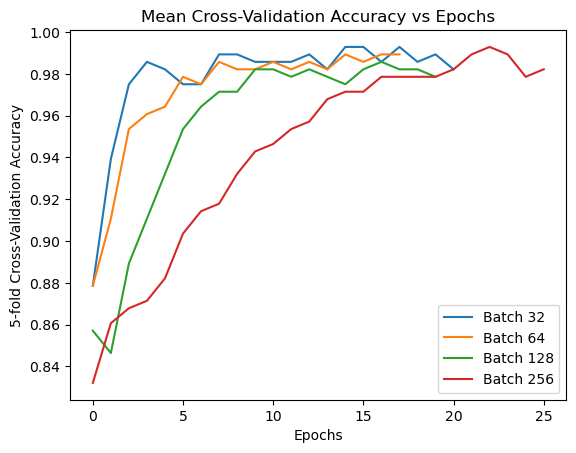

In [32]:
y1 = epoch_acc_dict[32]
plt.plot(y1, label = "Batch 32")

y2 = epoch_acc_dict[64]
plt.plot(y2, label = "Batch 64")

# Batch Size 8
y3 = epoch_acc_dict[128]
plt.plot(y3, label = "Batch 128")

# Batch Size 16
y4 = epoch_acc_dict[256]
plt.plot(y4, label = "Batch 256")

plt.xlabel('Epochs')
plt.ylabel('5-fold Cross-Validation Accuracy')
plt.title('Mean Cross-Validation Accuracy vs Epochs')
plt.legend()
plt.show()

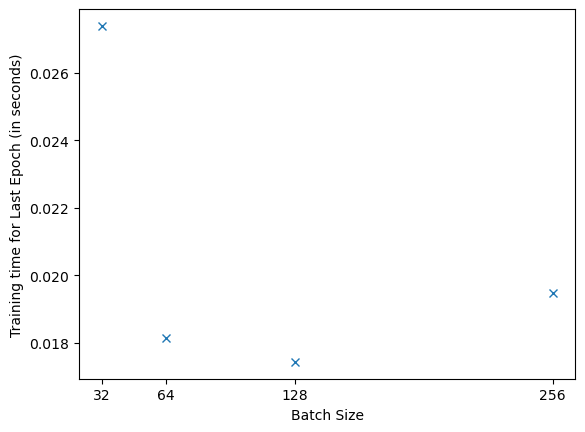

In [33]:
# TODO: Enter your code here
epoch_time_list = list()
for i in epoch_time_dict.values():
    epoch_time_list.append(i[0])
    
plt.plot(batch_size, epoch_time_list, marker = 'x', linestyle = 'None')
plt.xticks(batch_size)
plt.xlabel('Batch Size')
plt.ylabel('Training time for Last Epoch (in seconds)')
plt.show()

4. Create a table of time taken to train the network on the last epoch against different batch sizes. 

In [35]:
df2 = pd.DataFrame({'Batch Size': batch_size,
                   'Last Epoch Time (in seconds)': epoch_time_list})

df2

,Batch Size,Last Epoch Time (in seconds)
0,32,0.027385
1,64,0.018131
2,128,0.017437
3,256,0.019489


5. Select the optimal batch size and state a reason for your selection.

\# TODO: \<Enter your answer here\>

256, since it has the least training time for the last epoch (although it change sometimes)


Part A, Q3 (10 marks)
---
In this question, we will find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Q1 and Q2.

To reduce repeated code, you may need to import the network (MLP defined in QA1) from common_utils.py. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [39]:
# TODO: Enter your code here




> Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. 

1. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [42]:
from torch import optim
from common_utils import EarlyStopper

epoch_time_dict = {}
def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size, num_neurons):

    # YOUR CODE HERE
    
    epochs = 100
    
    # Convert input data to PyTorch tensors
    X_val_tensor = torch.FloatTensor(X_val_scaled)
    y_val_tensor = torch.LongTensor(y_val2)

    # Create DataLoader for training data
    train_dataset = AudioDataset(X_train_scaled, y_train2)
    test_dataset = AudioDataset(X_val_scaled, y_val2)
    
    # Creating Dataloader
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create and initialize the model
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Initialize EarlyStopper
    early_stopper = EarlyStopper(patience=3, min_delta=0)
    
    # Lists to store training information for plotting
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    times = []
    epoch_time = []
    
    # Record Time Taken for when Training Starts
    start_time = time.time()
    
    for epoch in range(epochs):
        
        # Record Time Taken for when Epochs Start
        epoch_start = time.time()
        
        model.train()
        total_loss = 0
        correct_train = 0

        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = total_loss / len(train_dataloader)
        train_accuracy = correct_train / len(train_dataloader.dataset)

        # Validation loop
        model.eval()
        total_loss = 0
        correct_test = 0

        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_test += (predicted == labels).sum().item()

            average_validation_loss = total_loss / len(test_dataloader)
            test_accuracy = correct_test / len(test_dataloader.dataset)
        
        # Early stopping check based on validation loss
        if early_stopper.early_stop(average_validation_loss):
            epoch_end = time.time() - epoch_start
            epoch_time.append(epoch_end)
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            print(f"Time Taken for Epoch: {epoch_end}")
            break

        # Append information for plotting
        train_losses.append(average_train_loss)
        test_losses.append(average_validation_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        times.append(time.time() - start_time)
        epoch_time_dict[num_neurons] = epoch_time
    

    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [43]:
# TODO: Enter your code here

no_neurons = [64, 128, 256]
bs = 256

epoch_acc_dict = {}

def find_optimal_hyperparameter(X_train, y_train, parameters, batch_size):

    # YOUR CODE HERE
    optimal_hyperparameters = {}
    cross_validation_accuracies = []
    cross_validation_times = []

    for num_neurons in parameters:
        # Initialize a list to store cross-validation accuracies for this number of neurons
        fold_accuracies = []
        fold_times = []

        # Perform k-fold cross-validation (e.g., k=5)
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # Initialise Fold Counter
        fold = 1
        
        for train_idx, val_idx in kf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

            # Create and train the neural network model
            model = MLP(no_features=X_train.shape[1], no_hidden=num_neurons, no_labels=2)
            train_accuracies, _, test_accuracies, _, times = train(model, X_train_fold, y_train_fold, X_val_fold, y_val_fold, batch_size, num_neurons)
            
            epoch_acc_dict[num_neurons] = test_accuracies

            #print(times)
            # Evaluate the model on the validation fold
            fold_accuracy = np.mean(test_accuracies)
            fold_time = np.mean(times)
 
            # Appending to the list
            fold_accuracies.append(fold_accuracy)
            fold_times.append(fold_time)
            
            print(f"Number of Hidden Neurons: {num_neurons} | Fold {fold} | Training Accuracy: {fold_accuracy}")
            
            fold += 1

        # Calculate the mean accuracy and time across all folds
        mean_accuracy = np.mean(fold_accuracies)
        mean_time = np.mean(fold_times)
        
        cross_validation_accuracies.append(mean_accuracy)
        cross_validation_times.append(mean_time)
        
        # if mode not in optimal_hyperparameters:
        #     optimal_hyperparameters[mode] = []
        # optimal_hyperparameters[mode].append(num_neurons)
        
        print(f"Mean Training Time: {mean_time} seconds")
        print(f"Mean 5-Fold Cross Validation Accuracy: {mean_accuracy}")
        print("----------------------------------------------------------------------------------")

    return cross_validation_accuracies, cross_validation_times


cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(df_train_scaled, y_train2, no_neurons, bs)

Early stopping triggered at epoch 39.
Time Taken for Epoch: 0.013948202133178711
Number of Hidden Neurons: 64 | Fold 1 | Training Accuracy: 0.9374060150375939
Early stopping triggered at epoch 41.
Time Taken for Epoch: 0.0168459415435791
Number of Hidden Neurons: 64 | Fold 2 | Training Accuracy: 0.8971428571428571
Early stopping triggered at epoch 52.
Time Taken for Epoch: 0.012864828109741211
Number of Hidden Neurons: 64 | Fold 3 | Training Accuracy: 0.939985994397759
Early stopping triggered at epoch 54.
Time Taken for Epoch: 0.012724161148071289
Number of Hidden Neurons: 64 | Fold 4 | Training Accuracy: 0.9446765498652289
Early stopping triggered at epoch 21.
Time Taken for Epoch: 0.012947320938110352
Number of Hidden Neurons: 64 | Fold 5 | Training Accuracy: 0.8801785714285714
Mean Training Time: 0.2751148354091463 seconds
Mean 5-Fold Cross Validation Accuracy: 0.919877997574402
----------------------------------------------------------------------------------
Early stopping trigge

2. Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}.

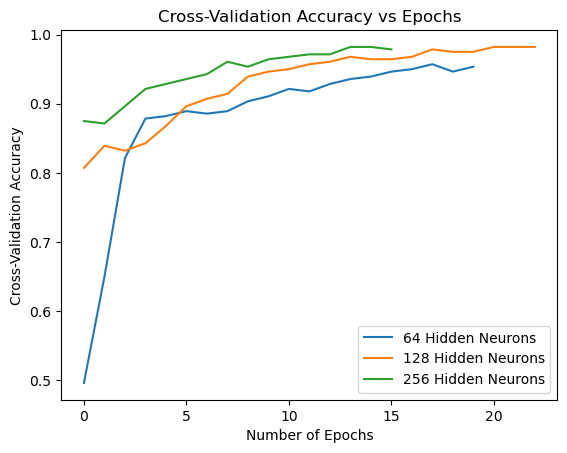

In [45]:
# TODO: Enter your code here

y1 = epoch_acc_dict[64]
plt.plot(y1, label = "64 Hidden Neurons")

# Hidden Neurons = 16
y2 = epoch_acc_dict[128]
plt.plot(y2, label = "128 Hidden Neurons")

# Hidden Neurons = 32
y3 = epoch_acc_dict[256]
plt.plot(y3, label = "256 Hidden Neurons")


plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy vs Epochs')
plt.legend()
plt.show() 

> Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [47]:
# TODO: Enter your code here

# i choose 256, since it has the most high accuracy 

\# TODO: \<Enter your answer here\>

i choose 256, since it has the most high accuracy, althogh it has a longer training time, i would prefer to trade-off it with the high accuracy rate.

> Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.
Note: use this optimal number of neurons for the rest of the experiments.

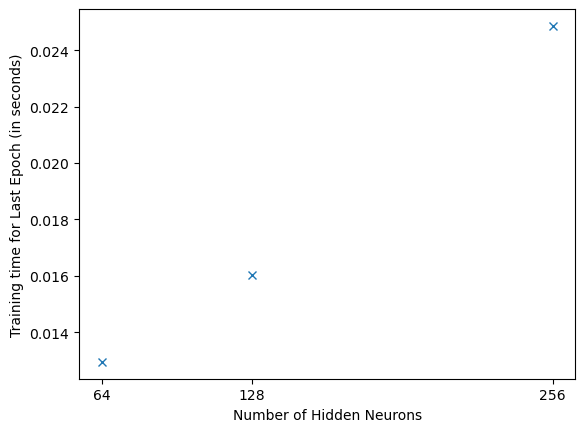

In [50]:
# TODO: Enter your code here
epoch_time_list = list()
for i in epoch_time_dict.values():
    epoch_time_list.append(i[0])
    
plt.plot(no_neurons, epoch_time_list, marker = 'x', linestyle = 'None')
plt.xticks(no_neurons)
plt.xlabel('Number of Hidden Neurons')
plt.ylabel('Training time for Last Epoch (in seconds)')
plt.show()

Part A, Q4 (10 marks)
---
In this section, we will understand the utility of such a neural network for a test audio. 

Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

To reduce repeated code, you may need to import the network (MLP defined in QA1) from **common_utils.py**. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [52]:
# TODO: Enter your code here

!pip install shap


> Install and import shap

In [54]:
# TODO: Enter your code here
import shap
from common_utils import extract_features

> Preprocess 'audio_test.wav' using the function 'extract_features' in common_utils.py. Please make sure the features are stored in a pandas dataframe, using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [56]:
import IPython
IPython.display.Audio("./audio_test.wav")

In [57]:
# TODO: Enter your code here
df = pd.DataFrame(extract_features("./audio_test.wav"))
size_row = 1
size_column = 58


In [58]:
df = df.drop(columns = ['filename'])

> Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 

 1.  Preprocess to obtain the test data, save the test data as numpy array, print the shape of the test data.

In [61]:
df_train_scaled

array([[ 0.65050004, -0.33473853,  1.49670942, ..., -0.29872091,
         0.07247372, -0.23610597],
       [ 0.04800008,  0.04346875,  0.69446787, ..., -0.37965311,
        -0.15191041, -0.34237611],
       [ 0.02565008,  0.52850302,  0.24072274, ..., -0.24625743,
         0.39231002, -0.29106861],
       ...,
       [-0.4882444 ,  0.85375983, -0.57084428, ...,  0.65794561,
        -0.25125447, -0.49512422],
       [-0.3246049 ,  0.47358987, -0.52185257, ...,  0.00828536,
         0.45230603,  0.09513055],
       [ 2.03159454, -2.54428041, -0.41945269, ..., -0.74732595,
         0.71358933, -0.83729985]])

In [62]:
df.shape

(1, 57)

In [63]:
# TODO: Enter your code here
batch_sizes = 256
no_neurons = 256
no_feature = 57
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
standard_scaler.fit(df_train_scaled)

X_test_scaled = standard_scaler.transform(df)




/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


2. Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [65]:
# TODO: Enter your code here

model = MLP(no_features=no_features, no_hidden=no_neurons, no_labels=2)
# model.load_state_dict(torch.load('pretrained_MLP.pth'))

# Set the model to evaluation mode
model.eval() 

# Convert the test data to a PyTorch tensor
X_test_tensor = torch.FloatTensor(X_test_scaled)
print(X_test_tensor.shape)
# Create a DataLoader with the optimal batch size
test_dataloader = DataLoader(X_test_tensor, batch_size=batch_sizes, shuffle=False)

# Initialize a list to store the predicted labels
predicted_labels = []

# Make predictions on the test data
with torch.no_grad():
    for inputs in test_dataloader:
        predictions = model(inputs)

        # Apply a threshold of 0.5 to obtain the predicted labels
        threshold = 0.5
        probabilities = torch.sigmoid(predictions)
        predicted_labels_batch = (probabilities > threshold).int()

        # Append the batch of predicted labels to the list
        predicted_labels.append(predicted_labels_batch)

# Concatenate the batches of predicted labels into a single tensor
pred_label = torch.cat(predicted_labels)
print(pred_label)

torch.Size([1, 57])
tensor([[0, 1]], dtype=torch.int32)


> Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

In [67]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
# TODO: Enter your code here

X_train_tensor = torch.FloatTensor(df_train_scaled) 
explainer = shap.DeepExplainer(model, X_train_tensor)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_tensor)

# Plot the local feature importance using a force plot
# Initialize JavaScript visualization
shap.initjs()  

# Convert SHAP values to Explanation object
expected_value = explainer.expected_value[0]
print(expected_value)
shap_values_explanation = shap.Explanation(shap_values, base_values=expected_value)
print(shap_values_explanation)

sample_idx = 0  
class_idx = 1

one_d_shap = shap_values_explanation.values[sample_idx, :, class_idx]

# Convert the test sample from a torch.Tensor to a NumPy array
X_test_sample_np = X_test_tensor[0].detach().numpy()

# Plot the local feature importance
max_features_to_display = 5
selected_feature_names = df.columns[:max_features_to_display]
shap.force_plot(
    expected_value,
    one_d_shap,
    X_test_sample_np,
    feature_names=selected_feature_names,
    figsize=(100, 6),
    text_rotation=45
)

0.5019341
.values =
array([[[ 2.45645879e-07,  5.65540574e-07],
        [ 3.92160437e-08, -1.25818730e-07],
        [-3.48498084e-08, -8.46110453e-08],
        [-8.81377371e-09, -1.13625687e-09],
        [-5.18739515e-04,  1.59051560e-03],
        [-9.77857411e-03, -1.54677138e-03],
        [-1.93158980e-04, -5.68136631e-04],
        [ 2.19757911e-02,  3.69202197e-02],
        [ 1.93598564e-04, -6.83762773e-04],
        [-5.13495684e-01,  4.51554596e-01],
        [-1.11695586e-08,  7.37942152e-10],
        [-3.22318061e-10, -9.99226657e-09],
        [-1.69735725e-10, -2.90525076e-10],
        [-4.99463937e-09, -4.68902384e-09],
        [ 5.32854975e-11,  1.10078252e-10],
        [-2.38911113e-09, -1.63508351e-09],
        [-6.16335892e-05,  2.61512701e-04],
        [ 2.26980828e-05, -3.80442099e-04],
        [ 2.01001574e-04,  1.17616459e-04],
        [-1.93400454e-04,  1.28554311e-04],
        [-1.24560844e-04,  4.16369439e-04],
        [ 1.00368277e-06,  7.40662074e-07],
        [ 5.

\# TODO: \<Enter your answer here\>
spectral_centroid_mean is the most important feature!

In [69]:
# spectral_centroid_mean is the most important feature!